# UMAP Visualization of Fashion MNIST Features

In this notebook, we'll visualize how our CNN model "sees" the Fashion MNIST dataset by extracting features from the model's layers and using UMAP to reduce their dimensionality for visualization. This will help us understand what patterns the model has learned and how it distinguishes between different clothing items.

First, let's import our required libraries:

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from models.fashion_model import FashionClassifier, load_pretrained_model, class_names

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Now let's load our trained model and the test dataset:

In [3]:
# Load the pretrained model
model = load_pretrained_model('models/fashion_mnist_model.pth')

# Prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Let's create a function to extract features from our model. We'll get features from the layer just before the final classification layer:


In [4]:
def extract_features(model, dataloader):
    features = []
    labels = []
    
    # Create a new model that extracts features before the final classification layer
    class FeatureExtractor(nn.Module):
        def __init__(self, original_model):
            super().__init__()
            # Extract all layers except the final fc2 layer
            self.conv1 = original_model.conv1
            self.bn1 = original_model.bn1
            self.conv2 = original_model.conv2
            self.bn2 = original_model.bn2
            self.pool = original_model.pool
            self.fc1 = original_model.fc1
            
        def forward(self, x):
            # Apply the same transformations as in the original model
            x = self.pool(torch.relu(self.bn1(self.conv1(x))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
            x = torch.relu(self.fc1(x))  # Get features from fc1
            return x
    
    # Create feature extractor and move to the same device as the model
    feature_extractor = FeatureExtractor(model)
    device = next(model.parameters()).device
    feature_extractor = feature_extractor.to(device)
    
    with torch.no_grad():
        for images, target in dataloader:
            # Move data to the same device as the model
            images = images.to(device)
            # Extract features
            batch_features = feature_extractor(images)
            # Move back to CPU for numpy conversion
            features.append(batch_features.cpu().numpy())
            labels.append(target.numpy())
    
    return np.vstack(features), np.concatenate(labels)

# Extract features
features, labels = extract_features(model, test_loader)


Now let's use UMAP to reduce the dimensionality of our features. UMAP is particularly good at preserving both local and global structure in the data:


In [5]:
# Create and fit UMAP
reducer = umap.UMAP(
    n_neighbors=15,    # Controls how local/global the embedding is
    min_dist=0.1,      # Controls how tightly points are packed
    n_components=2,    # Output dimensionality
    random_state=42    # For reproducibility
)

# Reduce dimensionality
embedding = reducer.fit_transform(features)

/Users/muntazirabidi/miniconda3/envs/ai_learning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/muntazirabidi/miniconda3/envs/ai_learning/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Finally, let's create a beautiful visualization:

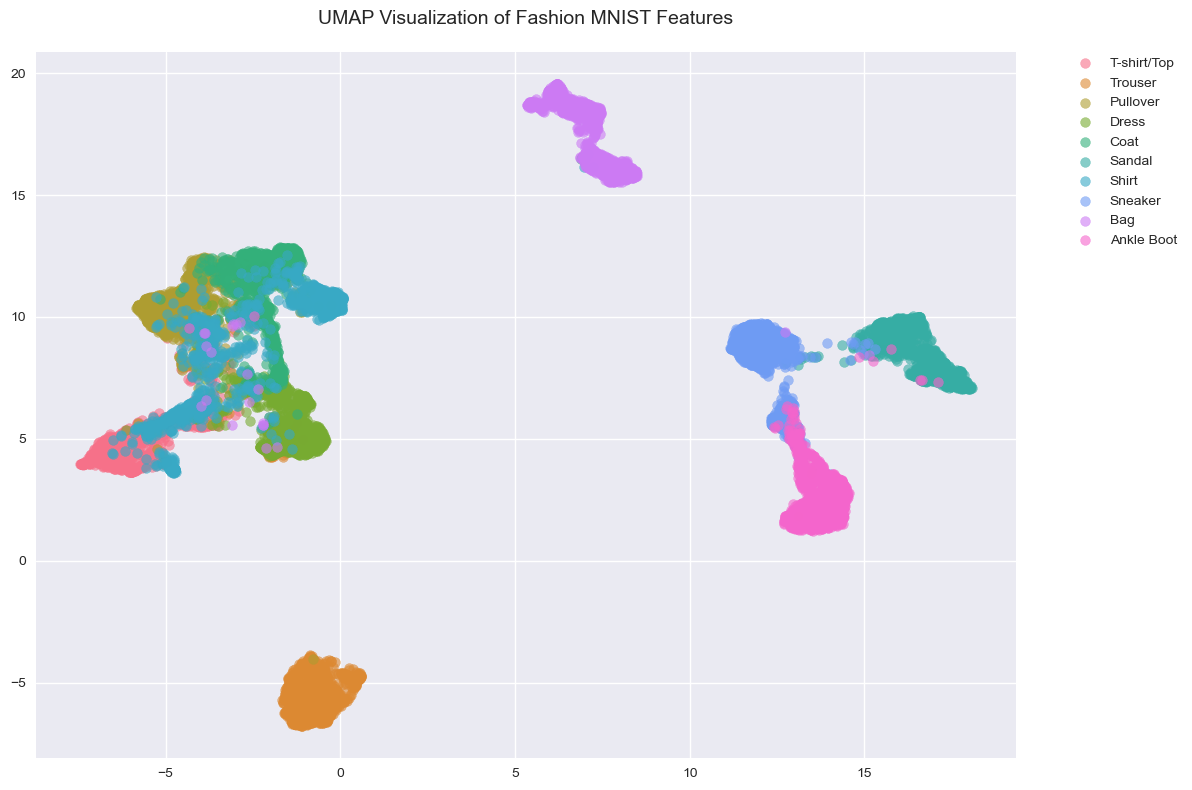

In [7]:
# Set up the plot style
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8')

# Define class names and colors
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
colors = sns.color_palette('husl', n_colors=10)

# Create scatter plot
for i, label in enumerate(class_names):
    mask = labels == i
    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        c=[colors[i]],
        label=label,
        alpha=0.6,
        s=50
    )

plt.title('UMAP Visualization of Fashion MNIST Features', size=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [10]:
import plotly.express as px
import pandas as pd
import numpy as np

# Create a DataFrame with our data
df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'Category': [class_names[l] for l in labels]
})

# Create an enhanced interactive plot
fig = px.scatter(
    df,
    x='UMAP1',
    y='UMAP2',
    color='Category',
    title='Feature Space Visualization of Fashion MNIST Categories',
    template='plotly_white',
    color_discrete_sequence=px.colors.qualitative.Set3,  # More distinguishable color palette
    hover_data=['Category'],
    width=1200,
    height=800
)

# Enhance the layout
fig.update_layout(
    title={
        'text': 'Feature Space Visualization of Fashion MNIST Categories',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    legend_title_text='Clothing Category',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02,
        bordercolor="Black",
        borderwidth=1
    ),
    plot_bgcolor='white',
    showlegend=True
)

# Enhance the axes
fig.update_xaxes(
    title_text='UMAP Dimension 1',
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='gray'
)

fig.update_yaxes(
    title_text='UMAP Dimension 2',
    showgrid=True,
    gridwidth=1,
    gridcolor='lightgray',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='gray'
)

# Update marker properties
fig.update_traces(
    marker=dict(size=8, opacity=0.7),
    selector=dict(mode='markers')
)

fig.show()

# Add an annotation explaining the visualization
text_annotation = """
This visualization shows how our CNN model understands different clothing categories in Fashion MNIST.
Points that are closer together represent items that the model sees as similar.
Clear separation between clusters indicates the model can distinguish these categories well.
"""


Let's analyze what we can learn from these visualizations:

1. Cluster Separation: Look for clear separations between different clothing categories. Well-separated clusters indicate that our model has learned distinctive features for those categories.

2. Overlapping Categories: Notice which categories tend to overlap. These are likely the ones our model sometimes confuses.

3. Subclusters: Sometimes we might see that a single category forms multiple clusters, suggesting that our model has learned to recognize different "styles" within that category.

We can also create additional visualizations to explore specific aspects:


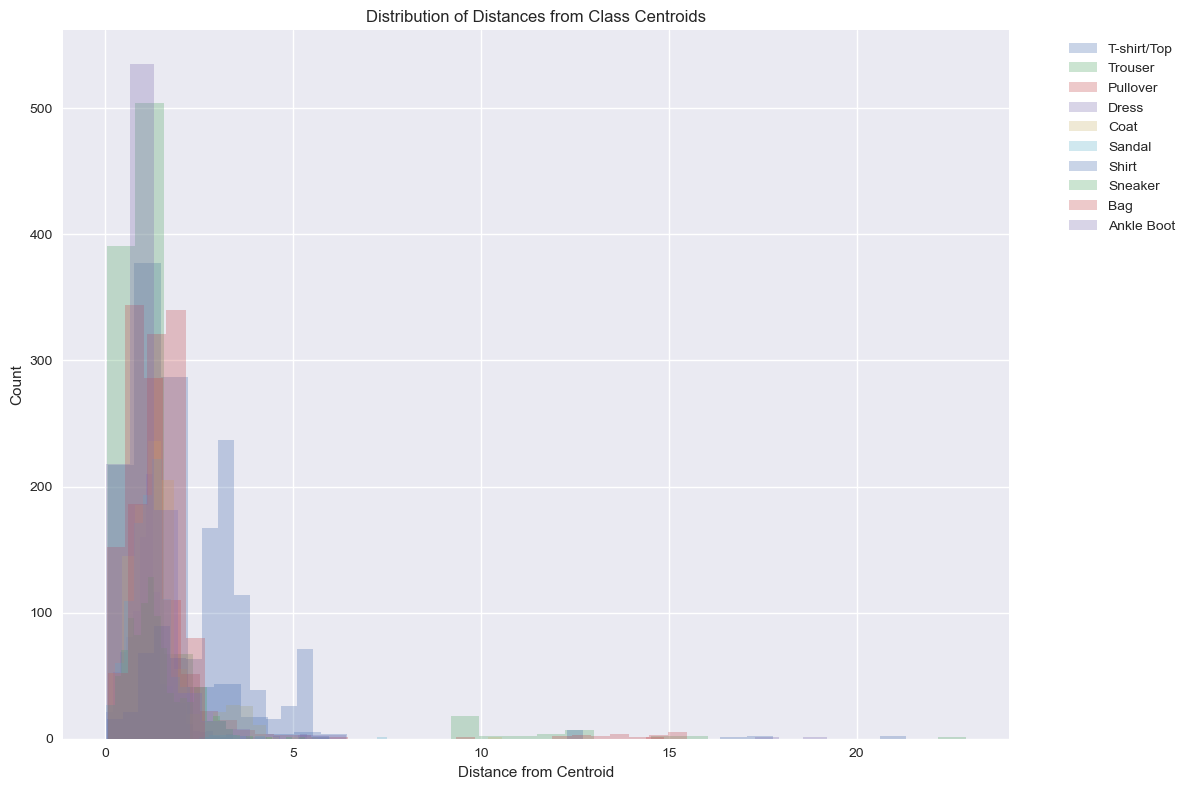

In [9]:
# Visualize distance relationships
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    mask = labels == i
    centroid = embedding[mask].mean(axis=0)
    distances = np.linalg.norm(embedding[mask] - centroid, axis=1)
    
    plt.hist(distances, bins=30, alpha=0.3, label=class_names[i])

plt.title('Distribution of Distances from Class Centroids')
plt.xlabel('Distance from Centroid')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This visualization helps us understand how "tight" each class cluster is, which can indicate how confident our model is in its classifications for different categories.

The UMAP visualization provides several insights about our model:
1. How well it separates different clothing categories
2. Which categories are most similar in the model's "understanding"
3. Whether there are any interesting subgroups within categories
4. How the model's feature space is organized

Would you like to explore any particular aspect of these visualizations in more detail? We could:
1. Analyze specific clusters more closely
2. Create additional visualizations for particular categories
3. Compare UMAP with other dimensionality reduction techniques like t-SNE
4. Explore features from different layers of the model